# Проект Яндекс.Недвижимость

В нашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. 

* Необходимо изучить рынок недвижимости и понять, какие факторы влияют на стоимость жилья

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

**План работы:**

* Импортировать все нужные библиотеки, и посмотреть на датасет

* Очистить датасет от пропусков

* Убрать аномалии

* Проанализировать параметры 

* Добавить несколько новых признаков

* Выявить взаимосвязь между параметрами

* Сделать выводы по результатам анализа

## Анализ данных

*Импорт необходимых библиотек*

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import phik

*В data читаем наш файл разделением табуляцией*

In [ ]:
data = pd.read_csv('real_estate_data (1).csv', sep='\t')

*Узнаем размерность таблицы*

In [ ]:
data.shape

*Смотрим на колонки и типы данных в них*

In [ ]:
data.info()

*Смотрим как выглядит наша таблица*

In [ ]:
display(data.head(6))

### Предобработка данных

**Считаем количество пропусков в таблице**

In [ ]:
data.isna().sum()

Визуализируем для наглядности

In [ ]:
def pass_value_barh(df):
        (
            (df.isna().mean()*100)
            .to_frame()
            .rename(columns = {0:'space'})
            .query('space > 0')
            .sort_values(by = 'space', ascending = True)
            .plot(kind= 'barh', figsize=(19,6), rot = -5, legend = False, fontsize = 16, color='pink', ec="black", lw= 1)
            .set_title('Пропуски в данных' + "\n", fontsize = 22, color = 'black')    
        );

In [ ]:
pass_value_barh(data)

*Наибольшее количество пропусков в is_apartment,parks_nearest и ponds_nearest.*

#### **is_apartment**

*Смотрим столбец 'is_apartment' так как в нем наибольшее количество пропусков*

In [ ]:
print(data['is_apartment'].value_counts())

*Есть предположение, что пропуски можно заполнить значением False, так как понятно, что в нем может быть только два варианта. И если не стоит True, значит скорее всего это False*

In [ ]:
data['is_apartment'] = data['is_apartment'].fillna(False)
print(data['is_apartment'].value_counts())

*Предварительно пропуски заполнились и теперь этот столбец имеет тип данных bool  как и должно быть*

*Посчитаем пропуски теперь*

In [ ]:
data['is_apartment'].isna().sum()

*Всего 50 апартаментов из всего датасета, не сильно популярный тип недвижимости*

#### **balcony**

*Посмотрим на столбец 'balcony'*

In [ ]:
data['balcony'].head()

*Можно предположить примерно то же, что и для 'is_apartment' - если бы балкон был, о нем была внесена информация, пропуски могут означать, что балкона нет, просто данные не были внесены или поставлен прочерк. Тогда заполняем пропуски нулями*

In [ ]:
data['balcony'].fillna(0, inplace=True)
print(data['balcony'].head())

*Теперь можно поменять тип данных, потому что тут явно целочисленные значения должны быть, балконов ведь не может быть 1,5 штуки*

In [ ]:
data['balcony'] = data['balcony'].astype('int')
print(data['balcony'].head())

In [ ]:
data['balcony'].value_counts()

*В основном балконов нет, 1 и 2 балкона в квартире встречаются примерно равное количество раз, больше - реже*

#### **total_images**

In [ ]:
data['total_images'].describe()

In [ ]:
plt.hist(data['total_images'], color = 'pink', bins=40, ec="black", lw= 1, range=(0, 40));
plt.title('Фотографии')
plt.xlabel('Количество фотографий')
plt.ylabel('Объекты');

#### **ceiling_height**

*Столбец 'ceiling_height' возможно связан с этажностью здания, чем выше, тем невыше потолки, хотя никакой явной корреляции нет. Однако можно разбить этажность на группы и по медианам групп заполнить пропуски*

*Посмотрим на характеристики столбца*

In [ ]:
data['ceiling_height'].describe()

*Странное максимальное значение, возможно стоит избавиться от аномальных значений по высоте потолков, все что больше 26 разделить на 10, может быть это ошибка в запятой*

In [ ]:
data.loc[data['ceiling_height'] >= 25, 'ceiling_height'] = data['ceiling_height'] / 10
data['ceiling_height'].describe()

*25 потому что если разделить на 10, получается 2.5, что нормально. Но если например взять только больше 20, то высота потолка получается 2 метра, а это очень мало*

In [ ]:
data.loc[data['ceiling_height'] >= 6, 'ceiling_height'] = data['ceiling_height'].median()
data.loc[data['ceiling_height'] <= 2, 'ceiling_height'] = data['ceiling_height'].median()
data['ceiling_height'].describe()

In [ ]:
x = sns.boxplot(data=data['ceiling_height'], palette="Set2")
x.set_title('Диаграмма размаха высоты потолков')
x.set_ylabel('Высота');

In [ ]:
plt.hist(data['ceiling_height'], color = 'pink', bins=12, ec="black", lw= 1, range=(2,5));
plt.title('Высота потолков')
plt.xlabel('Высота, м')
plt.ylabel('Количество квартир с такими потолками');

In [ ]:
for name in data['locality_name'].unique():
    data.loc[(data['ceiling_height'].isna() == True) & (data['locality_name'] == name), 'ceiling_height'] = \
    data.loc[(data['ceiling_height'].isna() == False) & (data['locality_name'] == name), 'ceiling_height'].median()
print(data['ceiling_height'].describe())    

*Общие характеристики выборки не сильно поменялись в результате заполнения пропусков медианным значением по городу, но появилось больше квартир, в которых потолок выше 2,5 и ниже 3 м, что выглядит более правдоподбно*

In [ ]:
plt.hist(data['ceiling_height'], color = 'pink', bins=12, ec="black", lw= 1, range=(2, 5));
plt.title('Высота потолков после заполнения пропусков')
plt.xlabel('Высота, м')
plt.ylabel('Количество квартир с такими потолками');

*Большинство потолков находятся в диапазоне от 2.5 м до 3м, что похоже на правду это стандартная высота*

#### **living_area и total_area** 

In [ ]:
data['living_area'].head()

In [ ]:
print(data['living_area'].describe())

In [ ]:
x = sns.boxplot(data=data['total_area'], palette="Set2")
x.set_title('Диаграмма размаха общей площади')
x.set_ylabel('Площадь');

In [ ]:
x = sns.boxplot(data=data['living_area'], palette="Set2")
x.set_title('Диаграмма размаха жилой площади')
x.set_ylabel('Площадь');

In [ ]:
plt.hist(data['total_area'], color = 'pink', bins=35, ec="black", lw= 1, range=(0,300));
plt.title('Общая площадь')
plt.xlabel('кв.м.')
plt.ylabel('Количество квартир с такой площадью');

In [ ]:
plt.hist(data['living_area'], color = 'pink', bins=35, ec="black", lw= 1, range=(0,300));
plt.title('Жилая площадь')
plt.xlabel('кв.м.')
plt.ylabel('Количество квартир с такой площадью');

*Опять непонятное максимальное значение в 900м^2, возможно опять нужно отсеить аномалии и посмотреть не сильно ли это повлияло на количество данных*

In [ ]:
data = data = data.loc[data['total_area'] < 250]
print(data.shape)

*Немного данных почистилось, но в пределах разумного, 250 м квартиры конечно бывают, но точно не 900, и даже не 500. Немного даже частных домов имеет такую метражность*

*Разбиваем данные на группы по общей площади и на основе этого считаем у них медианное значение жилой площади, затем заполняем ими пропуски*

In [ ]:
one = data.loc[data['total_area'] <= 40, 'living_area'].median()
two = data.loc[(data['total_area'] > 40) & (data['total_area'] <= 52), 'living_area'].median()
three = data.loc[(data['total_area'] > 52) & (data['total_area'] <= 70), 'living_area'].median()
four = data.loc[data['total_area'] > 70, 'living_area'].median()

In [ ]:
data.loc[(data['living_area'].isna() == True) & (data['total_area'] <= 40), 'living_area'] = one

data.loc[(data['living_area'].isna() == True) & (data['total_area'] > 40) & (data['total_area'] <= 52), 'living_area'] = two

data.loc[(data['living_area'].isna() == True) & (data['total_area'] > 52) & (data['total_area'] <= 70), 'living_area'] = three

data.loc[(data['living_area'].isna() == True) & (data['total_area'] > 70), 'living_area'] = four

print(data['living_area'].isna().sum())

In [ ]:
print(data['living_area'].head())

*Здесь  тип float нужен, так что оставим его*

In [ ]:
data['total_area'].describe()

*Больше половины квартир имеют общую площадь свыше 52 кв.м., больше 75% - свыше 70 кв.м.*

Посмотрим поближе

In [ ]:
plt.figure(figsize=(15,3));
plt.hist(data['total_area'], color = 'pink', bins=152, ec="black", lw= 1, range=(10, 200))
plt.title('Общая площадь')
plt.xlabel('Площадь, м.кв.')
plt.ylabel('Объявления');

In [ ]:
data['total_area'].describe()

In [ ]:
plt.figure(figsize=(15,3));
plt.hist(data['total_area'], color = 'pink', bins = 30, ec = "black", lw = 1, range = (10, 25))
plt.title('Общая площадь, в масштабе')
plt.xlabel('Площадь, м.кв.')
plt.ylabel('Объявления');

т.е. все квартиры менее 20-ти квадратных метров можно считать редкостями особенно это заметно на втором графике

In [ ]:
data = data[(data['total_area'] > 20) | (data['rooms'].isna())]
data['total_area'].describe()

Посмотрю другой хвост выборки

In [ ]:
plt.figure(figsize=(15,3));
plt.hist(data['total_area'], color = 'pink', bins = 30, ec = "black", lw = 1, range = (125,250))
plt.title('Общая площадь, в масштабе')
plt.xlabel('Площадь, м.кв.')
plt.ylabel('Объявления');

Действительно, характеристика столбца не поменялась, кроме минимального значения

Стоит посмотреть жилую площадь на предмет выбросов 

In [ ]:
plt.figure(figsize=(15,3));
plt.hist(data['living_area'], color = 'pink', bins = 50, ec = "black", lw = 1)
plt.title('Жилая площадь')
plt.xlabel('Площадь, м.кв.')
plt.ylabel('Объявления');

In [ ]:
data = data[(data['living_area'] > 9) | (data['living_area'].isna())]
data = data[(data['living_area'] < 120) | (data['living_area'].isna())]
data['living_area'].describe()

####  **floors_total**

*у 'floor' заметная корреляция только с 'floors_total', но поскольку пропусков очень мало, я думаю можно просто взять этаж в колонке floor как последний и указать его в floors_total*

In [ ]:
data['floors_total'].describe()

In [ ]:
plt.hist(data['floors_total'], color = 'pink', bins=29, ec="black", lw= 1, range=(1,30));
plt.title('Этажей в здании')
plt.xlabel('Этажи')
plt.ylabel('Количество квартир в домах с такой этажностью');

*Часто встречаются квартиры на продажу в домах, где всего 6 или 9 этажей, это скорее всего просто самая часто встречающаяся этажность зданий в Питере*

In [ ]:
data['floors_total'].fillna(data['floor'], inplace=True)

print(data['floors_total'].isna().sum())

In [ ]:
data['floors_total'] = data['floors_total'].astype('int')
print(data['floors_total'].head())

In [ ]:
data = data[(data['floors_total'] < 30) | (data['floors_total'].isna())]

data['floors_total'].describe()

####  **first_day_exposition**

*Работа со столбцом 'first_day_exposition', так как в  info() я заметила, что тип данных был object, а должен быть datetime64*

In [ ]:
print(data['first_day_exposition'].head())

*Видно, что дата в неправильном формате, это нужно изменить*

In [ ]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')
print(data['first_day_exposition'].head())

**Считаем явные дубликаты:**

In [ ]:
data.duplicated().sum()

*Их нет, значит смотрим на неявные*

#### **locality_name**

**Посмотрим на уникальные значения столбца 'locality_name', он вызывает больше всего вопросов**

In [ ]:
data['locality_name'].unique().tolist()

*Внушительный список, посчитаем сколько всего уникальных значений на данный момент*

In [ ]:
len(data['locality_name'].unique())

*То есть уникальных значений 365, и сразу видно, что некоторые НП написаны разными способами, я составила таблицу и отсортировала все неявные дубликаты и теперь занесла их в метод replace()*

In [ ]:
data['locality_name'] = data['locality_name'].str.replace('посёлок','поселок')

In [ ]:
data['locality_name'] = data['locality_name'].replace('поселок Мурино','Мурино')
data['locality_name'] = data['locality_name'].replace('деревня Кудрово','Кудрово')
data['locality_name'] = data['locality_name'].replace('Коммунар','поселок Коммунары')
data['locality_name'] = data['locality_name'].replace('городской поселок Фёдоровское','деревня Фёдоровское')
data['locality_name'] = data['locality_name'].replace('село Никольское','Никольское')
data['locality_name'] = data['locality_name'].replace('городской поселок Рощино','поселок городского типа Рощино')
data['locality_name'] = data['locality_name'].replace('коттеджный поселок Лесное','поселок Лесное')
data['locality_name'] = data['locality_name'].replace('поселок Любань','Любань')
data['locality_name'] = data['locality_name'].replace('поселок при железнодорожной станции Приветнинское','поселок станции Приветнинское')
data['locality_name'] = data['locality_name'].replace('деревня Гарболово','поселок Гарболово')
data['locality_name'] = data['locality_name'].replace('городской поселок Назия','поселок городского типа Назия')
data['locality_name'] = data['locality_name'].replace('поселок Щеглово','деревня Щеглово')
data['locality_name'] = data['locality_name'].replace('поселок при железнодорожной станции Вещево','поселок станции Вещево')
data['locality_name'] = data['locality_name'].replace('городской поселок Мга','посёлок городского типа Мга')
data['locality_name'] = data['locality_name'].replace('поселок городского типа Рябово','поселок Рябово')
data['locality_name'] = data['locality_name'].replace('поселок Зимитицы','деревня Зимитицы')
data['locality_name'] = data['locality_name'].replace('городской поселок Лесогорский','поселок городского типа Лесогорский')
data['locality_name'] = data['locality_name'].replace('поселок городского типа Большая Ижора','городской поселок Большая Ижора')
data['locality_name'] = data['locality_name'].replace('поселок городского типа Советский','городской посёлок Советский')
data['locality_name'] = data['locality_name'].replace('городской поселок Павлово','село Павлово')
data['locality_name'] = data['locality_name'].replace('поселок городского типа Павлово','село Павлово')

*Еще раз посмотрим на уникальные значения этого столбца*

In [ ]:
data['locality_name'].unique().tolist()

*Теперь снова посчитаем количество уникальных значений, теперь их на 53 меньше*

In [ ]:
len(data['locality_name'].unique())

*Теперь всем пропускам присвоим значение 'unknown' так как заполнить эти пропуски не представляется возможным, и посчитаем все пропуски для проверки*

In [ ]:
data['locality_name'] = data['locality_name'].fillna('unknown')
data['locality_name'].isna().sum()

#### **parks_around3000 и ponds_around3000**

*С прудами и парками все сложно, ближайшие пруды/парки можно заполнить нулями, видимо в радиусе 3 км нет никого из них. Про ближайшие пруды/парки вообще ничего не известно, и корреляции вменяемой нет ни с каким столбцом, поэтому видимо придется оставить с пропусками*

In [ ]:
data['parks_around3000'].fillna(0, inplace=True)
data['ponds_around3000'].fillna(0, inplace=True)

In [ ]:
plt.hist(data['parks_around3000'], color = 'pink', bins=4, ec="black", lw= 1, range=(0,4));
plt.title('Парки поблизости')
plt.xlabel('Количество парков')
plt.ylabel('Объекты');

In [ ]:
plt.hist(data['ponds_around3000'], color = 'pink', bins=4, ec="black", lw= 1, range=(0,4));
plt.title('Пруды поблизости')
plt.xlabel('Количество прудов')
plt.ylabel('Объекты');

#### **ponds_nearest и parks_nearest**

In [ ]:
plt.figure(figsize=(15,3));
plt.hist(data['parks_nearest'], color = 'pink', bins=100, ec="black", lw= 1);
plt.title('Ближайший парк')
plt.xlabel('Расстояние до парка')
plt.ylabel('Объекты');

In [ ]:
plt.figure(figsize=(15,3));
plt.hist(data['ponds_nearest'], color = 'pink', bins=100, ec="black", lw= 1);
plt.title('Ближайший пруд')
plt.xlabel('Расстояние до пруда')
plt.ylabel('Объекты');

#### **kitchen_area**

In [ ]:
plt.hist(data['kitchen_area'], color = 'pink', bins=29, ec="black", lw= 1, range=(1,30));
plt.title('Площадь кухни')
plt.xlabel('кв.м.')
plt.ylabel('Количество квартир в домах с такой площадью кухни');

In [ ]:
data['kitchen_area'].describe()

*Сейчас строк, подходящих под условие, что жилая площадь и кухня больше 0,9 от общей площади - 530 штук*

In [ ]:
len(data.query('total_area*0.9 <= (living_area + kitchen_area)'))

*То есть аномальных значений стало не намного больше, возможно это те квартиры, где нет балкона*

In [ ]:
data = data[(data['kitchen_area'] > 3) | (data['kitchen_area'].isna())]
data = data[(data['kitchen_area'] < 50) | (data['kitchen_area'].isna())]
print(data['kitchen_area'].describe())

In [ ]:
len(data.query('total_area*0.9 <= (living_area + kitchen_area)'))

*Аномалий стало на 12 меньше*

*Еще раз посмотрим на график*

In [ ]:
plt.hist(data['kitchen_area'], color = 'pink', bins=29, ec="black", lw= 1, range=(1,30));
plt.title('Площадь кухни')
plt.xlabel('кв.м.')
plt.ylabel('Количество квартир в домах с такой площадью кухни');

*Большинство кухонь, видимо 7, 9 и 11 кв.м.*

Почистим от выбросов

In [ ]:
data = data[(data['kitchen_area'] > 4) | (data['kitchen_area'].isna())]
data = data[(data['kitchen_area'] < 35) | (data['kitchen_area'].isna())]
data['kitchen_area'].describe()

#### **days_exposition**

In [ ]:
data['days_exposition'].head()

In [ ]:
plt.hist(data['days_exposition'], color = 'pink', bins=50, ec="black", lw= 1, range=(0, 1400));
plt.title('Дни объявления')
plt.xlabel('Дни')
plt.ylabel('Объявления');

*Абсолютное большинство объявлений не висит дольше 200 дней, и так как пропусков много и заполнить их нечем, то и тип float на int не поменять*

In [ ]:
(
    data[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',  'kitchen_area',
          'floor', 'floors_total']]
    .apply (['count', 'min', 'max'])   
    .style.format("{:,.2f}")
)

In [ ]:
data['days_exposition'].describe()

*Думаю не имеет смысла рассматривать объявления, которые висят дольше 2 лет, за это время и цена могла поменяться и человек мог просто забыть снять с объявления*

In [ ]:
data = data[(data['days_exposition'] < 730) | (data['days_exposition'].isna())]
data['days_exposition'].describe()

In [ ]:
data = data[(data['days_exposition'] > 10) | (data['days_exposition'].isna())]
data['days_exposition'].describe()

#### **rooms**

In [ ]:
data.rooms.value_counts().to_frame()

In [ ]:
data = data[(data['rooms'] < 8) | (data['rooms'].isna())]
data['rooms'].describe()

In [ ]:
plt.hist(data['rooms'], color = 'pink', bins=7, ec="black", lw= 1);
plt.title('Комнаты')
plt.xlabel('Количество')
plt.ylabel('Объявления');

#### **last_price**

In [ ]:
print(data['last_price'].describe())

*Очень неудобно читать эти цифры, сделаю в нем значения равные миллиону*

In [ ]:
data['last_price_mill'] = data['last_price']/1000000
print(data['last_price_mill'].describe())

In [ ]:
plt.figure(figsize=(15,3));
plt.hist(data['last_price_mill'], color = 'pink', bins=60, ec="black", lw= 1, range=(0, 60))
plt.title('Цена объекта')
plt.xlabel('Цена, миллионы')
plt.ylabel('Объявления');

*Квартира не может стоить меньше 1 миллиона и значений больше 60 миллионов вряд ли имеет смысл рассматривать*

In [ ]:
data = data[(data['last_price_mill'] < 60) | (data['last_price_mill'].isna())]
data = data[(data['last_price_mill'] > 1) | (data['last_price_mill'].isna())]
print(data['last_price_mill'].describe())

In [ ]:
(
    data[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',  
        'kitchen_area', 'floor',   'floors_total']]
    .quantile([0.01, .5, .90, .9976])  
    .style.format("{:,.2f}")
)

#### **cityCenters_nearest**

In [ ]:
data['cityCenters_nearest'].describe()

In [ ]:
plt.figure(figsize=(15,3));
plt.hist(data['cityCenters_nearest'], color = 'pink', bins=100, ec="black", lw= 1)
plt.title('Расстоние до центра города, м')
plt.xlabel('Расстояние')
plt.ylabel('Объявления');

*Интересный провал в объявлениях на 40 км от центра, там вообще почти нет квартир. при этом дальше, на 50 км объявления есть. Много квартир от 10 до 20 км до центра города, а также примерно в 5 км от центра есть достаточно большое количество объявлений.* 

### Новые признаки

#### **price_mkv**

**Цена одного квадратного метра**

In [ ]:
data['price_mkv'] = data['last_price'] / data['total_area']
print(data['price_mkv'])

#### **day**

**День публикации объявления (0 - понедельник, 1 - вторник и т.д.)**

In [ ]:
data['day'] = pd.DatetimeIndex(data['first_day_exposition']).weekday
print(data['day'].head())

#### **month**

**Месяц публикации объявления**

In [ ]:
data['month'] = pd.DatetimeIndex(data['first_day_exposition']).month
print(data['month'].head())

#### **year**

**Год публикации объявления**

In [ ]:
data['year'] = pd.DatetimeIndex(data['first_day_exposition']).year
print(data['year'].head())

#### **floor_type**

**Тип этажа квартиры (значения — «первый», «последний», «другой»)**

In [ ]:
data['floor'].describe()

In [ ]:
def floor_identity(floor):
    if floor['floor'] == 1:
        return 'первый'
    elif floor['floor'] == floor['floors_total']:
        return 'последний'
    else:
        return 'другой'

data['floor_type'] = data.apply(floor_identity, axis=1)
print(data['floor_type'].head())

#### **center_km**

**Расстояние в км до центра города**

In [ ]:
data['center_km'] = data['cityCenters_nearest'] / 1000

print(data['center_km'])

In [ ]:
data['center_km'] = round(data['center_km'])
print(data['center_km'].head())

***Итог***

*В датасет добавлены столбцы цена одного квадратного метра, день публикации объявления (0 - понедельник, 1 - вторник и т.д.), месяц публикации объявления, год публикации объявления, тип этажа квартиры (значения — «первый», «последний», «другой»), расстояние в км до центра города*

Убираем лишние столбцы

In [ ]:
data = data.drop('first_day_exposition', axis=1)
data = data.drop('last_price', axis=1)
data = data.drop('cityCenters_nearest',axis=1)

## Доп. Графики

### **Матрица корреляций**

In [ ]:
display(data.head())

In [ ]:
data.columns

In [ ]:
int_cols = ['total_area', 'ceiling_height',\
       'living_area', 'kitchen_area', 'airports_nearest',\
       'parks_nearest','ponds_nearest',\
       'last_price_mill', 'price_mkv', 'center_km']

matrix = round(data.phik_matrix(interval_cols=int_cols), 2)
plt.figure(figsize=(16,12))
plt.suptitle('Матрица корреляции признаков')
sns.heatmap(matrix, cmap="coolwarm", annot=True)
plt.tight_layout();

### **floor**

In [ ]:
data['floor'].describe()

In [ ]:
plt.hist(data['floor'], color = 'pink', bins=26, ec="black", lw= 1);
plt.title('Этаж')
plt.xlabel('Номер этажа')
plt.ylabel('Объявления');

*Большинство квартир находится на 2 и 3 этажах, большинство квартир находится с 1 по 6 этажи*

### **floor_type**

In [ ]:
data['floor_type'].describe()

In [ ]:
plt.hist(data['floor_type'], color = 'pink', bins=5, ec="black", lw= 1);
plt.title('Тип этажа')
plt.xlabel('Этаж')
plt.ylabel('Объявления');

*Данный график подтверждает предыдущие выводы, большинство квартир находятся не на первом и не на последнем этажах*

### **day**

In [ ]:
plt.hist(data['day'], color = 'pink', bins=13, ec="black", lw= 1);
plt.title('День публикации')
plt.xlabel('День недели')
plt.ylabel('Объявления');

*Реже всего объявления размещают в выходные, предполагаю, что это связано с тем, что размещением часто занимаются агенты, а у них рабочая неделя стандартная*

### **month**

In [ ]:
plt.hist(data['month'], color = 'pink', bins=23, ec="black", lw= 1);
plt.title('Месяц публикации')
plt.xlabel('Номер месяца')
plt.ylabel('Объявления');

*Чаще всего объявления размешают в феврале-марте-апреле, потом спад, а затем снова плавный подъем с пиком в ноябре*

### **days_exposition**

In [ ]:
data['days_exposition'].describe()

In [ ]:
plt.hist(data['days_exposition'], color = 'pink', bins=49, ec="black", lw= 1);
plt.title('Время объявления')
plt.xlabel('Количество дней')
plt.ylabel('Объявления');

In [ ]:
plt.figure(figsize=(15,3));
plt.hist(data['days_exposition'], color = 'pink', bins=74, ec="black", lw= 1, range=(25, 100));
plt.title('Время объявления, в масштабе')
plt.xlabel('Количество дней')
plt.ylabel('Объекты');

*Пики в 45, 60 и 90 дней, далее становится ясно почему*

In [ ]:
days_mean = data.pivot_table(index='year', values='days_exposition', aggfunc=['count','mean'])
days_mean.columns = ['count', 'mean']
print(days_mean)

*То есть больше всего объявлений за 2017 и 2018ые года, и меньше всего висят объявления 2019 года? Может он просто еще не закончился, когда выгружали датасет*

In [ ]:
dem = data['days_exposition'].mode()
print(dem)

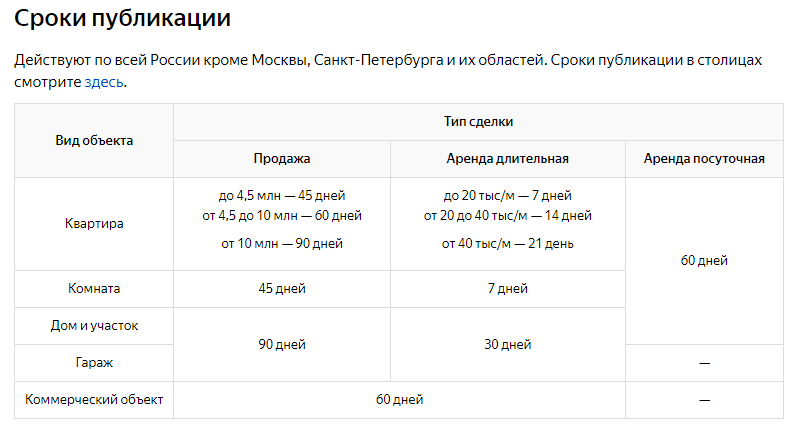

*Условия сроков публикации объявлений вносят ясности, то есть квартиры до 4.5млн висит до 45 дней, до 10млн - 60 дней, от 10млн - 90 дней. И получается либо продается за этот срок, либо заново публикуется. Из моды по данному столбцу также ясно, что большинство квартир стоят до 4.5млн*

### Влияния

*Сначла соберу все необходимые данные в отдельную таблицу*

In [ ]:
corr_data = data[['last_price_mill', 'total_area', 'living_area', 'kitchen_area', 'rooms', 'floor_type','day','month', 'year']]
display(corr_data.head())

#### *'last_price_mill' и 'total_area'*

In [ ]:
corr_data.plot(x='total_area', y='last_price_mill', kind='scatter',alpha=0.6,\
              edgecolor='black', linewidth=1, c='last_price_mill', cmap='Set1');
plt.xlabel('Общая площадь')
plt.ylabel('Цена в мл.')
plt.title('Цена и общая площадь');

In [ ]:
data['last_price_mill'].corr(data['total_area'])

*Видно, что цена достаточно явно зависит от общей площади объекта, корреляция почти в 0,75 - это сильная корреляция*

#### *'last_price' и 'living_area'*

In [ ]:
corr_data.plot(x='living_area', y='last_price_mill', kind='scatter', alpha=0.6, \
              edgecolor='black', linewidth=1, c='last_price_mill', cmap='Set1');
plt.xlabel('Жилая площадь')
plt.ylabel('Цена в мл.')
plt.title('Цена и жилая площадь');

In [ ]:
data['last_price_mill'].corr(data['living_area'])

*Чуть меньше зависит цена от метража жилой площади, корреляция в 0,64*

#### *'last_price' и 'kitchen_area'*

In [ ]:
corr_data.plot(x='kitchen_area', y='last_price_mill', kind='scatter', alpha=0.6, \
              edgecolor='black', linewidth=1, c='last_price_mill', cmap='Set1');
plt.xlabel('Площадь кухни')
plt.ylabel('Цена в мл.')
plt.title('Цена и площадь кухни');

In [ ]:
data['last_price_mill'].corr(data['kitchen_area'])

*Еще меньше цена зависит от площади кухни, но все равно зависимость ненулева, значит люди все таки смотрят на размер кухни*

#### *'last_price' и 'rooms'*

In [ ]:
corr_data.plot(x='rooms', y='last_price_mill', kind='scatter', alpha=0.6, \
              edgecolor='black', linewidth=1, c='last_price_mill', cmap='Set1');
plt.xlabel('Количество комнат')
plt.ylabel('Цена в мл.')
plt.title('Количество комнат и цена');

*Квартиры без комнат (студии) обычно не стоят выше 10 мл. Квартиры с одной комнатой обычно не стоят выше 30 мл, но есть объявления и за 40 мл. Квартиры с двумя комнатами уже могут стоить и 55 мл., но самые дорогие квартиры - с 4 комнатами. Много квартир с 3 комнатами стоят около 30 мл. Странно что квартиры с 7 комнатами не стоят выше 30 мл, но и ниже 10 мл они тоже не стоят*

#### *'last_price' и 'floor_type'*

In [ ]:
corr_data.plot(x='floor_type', y='last_price_mill', kind='scatter', alpha=0.6, \
              edgecolor='black', linewidth=1, c='last_price_mill', cmap='Set1');
plt.xlabel('Тип этажа')
plt.ylabel('Цена в мл.')
plt.title('Цена и тип этажа');

*Среди цен за первый и за последний этаж меньше высоких, в основном высокие цены за квартиры на других этажах*

#### *'last_price' и 'day'*

In [ ]:
corr_data.plot(x='day', y='last_price_mill', kind='scatter', alpha=0.6, \
              edgecolor='black', linewidth=1, c='last_price_mill', cmap='Set1');
plt.xlabel('День недели')
plt.ylabel('Цена в мл.')
plt.title('Цена и день публикации');

*Цена не зависит от дня недели размещения объявления, хотя объявления выставленные в воскресенье не имеют таких высоких цен*

####  *'last_price' и 'month'*

In [ ]:
corr_data.plot(x='month', y='last_price_mill', kind='scatter', alpha=0.6, \
              edgecolor='black', linewidth=1, c='last_price_mill', cmap='Set1');
plt.xlabel('Месяц')
plt.ylabel('Цена в мл.')
plt.title('Цена и месяц публикации');

*Цена также не зависит от месяца размещения объявления*

#### *'last_price' и 'year'*

In [ ]:
corr_data.plot(x='year', y='last_price_mill', kind='scatter', alpha=0.6, \
              edgecolor='black', linewidth=1, c='last_price_mill', cmap='Set1');
plt.xlabel('Год')
plt.ylabel('Цена в мл.')
plt.title('Цена и год публикации');

*Похоже что старые квартиры стоят меньше, а самые дорогие квартиры были выставлены в 2016 году*

### Доп. расчеты

**Посчитаем среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений и выделим населённые пункты с самой высокой и низкой стоимостью квадратного метра.**

*Сначала посчитаю города в которых больше всего объявлений*

In [ ]:
loc_freq = data['locality_name'].value_counts()
print(loc_freq.head(10))

*Создам отдельную переменную, чтобы потом к ней обратиться и сделаю срез с значениями только по нужным городам*

In [ ]:
loc_freq_ten = ['Санкт-Петербург', 'Мурино', 'Кудрово', 'поселок Шушары', 'Всеволожск', 'Пушкин', \
                'Колпино', 'поселок Парголово', 'Гатчина', 'Выборг']
data_ten = data.query('locality_name in @loc_freq_ten')
display(data_ten.head(10))

*Выберу из этой таблицы только нужные для подсчета столбцы*

In [ ]:
data_ten = data_ten[['locality_name', 'price_mkv']]
print(data_ten.head())

*Расчитаю среднее значение цены за м.кв. по каждому населенному пункту*

In [ ]:
data_ten_table = round(data_ten.pivot_table(index='locality_name', values='price_mkv', aggfunc='mean'),1)
display(data_ten_table)

In [ ]:
data_ten_table = data_ten_table.reset_index()
data_ten_table.columns = ['locality_name', 'price_mkv']
display(data_ten_table)

In [ ]:
data_ten_table = data_ten_table.sort_values('price_mkv', ascending=False)

In [ ]:
plt.figure(figsize=(15,6.5))
sns.set_style('darkgrid')
g = sns.barplot(data=data_ten_table, x='locality_name', y='price_mkv', ci=False, palette='viridis');
g.set_xticklabels(data_ten_table['locality_name'], rotation=55, fontdict={'fontsize':10});
plt.xlabel('Город')
plt.ylabel('Цена за кв.м.')
plt.title('Города по цене за м.кв.')
plt.show();

*Вывод:*

1) В Санкт-петербурге самая высокая средняя стоимость квадратного метра недвижимости, в Пушкине тоже получается достаточно высокая

2) В Выборге получается самая низкая средняя стоимость квадратного метра

**Теперь можно вычислить среднюю цену каждого километра**

*Смотрю на выброс на 27 км*

In [ ]:
display(data[(data['center_km'] == 27) & (data['locality_name'] == 'Санкт-Петербург')])

*за 74 м.кв. цена в 14 миллионов не выглядит адекватно, так что придется выбросить это значение* 

In [ ]:
data = data.drop(index = data.query('center_km == 27 and last_price_mill == 14.35').index)
display(data[(data['center_km'] == 27) & (data['locality_name'] == 'Санкт-Петербург')])

*выберем только данные по СПб, а также выберем только нужные нам столбцы - это цена и расстояние в км до центра*

In [ ]:
data_saint_p = data.loc[data['locality_name'] == 'Санкт-Петербург']
data_saint_pp = data_saint_p[['locality_name', 'center_km', 'last_price_mill', 'price_mkv']]
display(data_saint_pp.head())

*Создадим новый столбец для цены каждого км от центра города*

*Построю дополнительный столбец с количеством объявлений на каждом километре, чтобы разобраться что происходит на 3 и 5 км*

In [ ]:
dsppt = data_saint_pp.pivot_table(index='center_km', values='price_mkv', aggfunc=['count', 'mean'])
dsppt = dsppt.reset_index()
dsppt.columns = ['center_km', 'count_price_mkv', 'mean_price_mkv']
display(dsppt)

In [ ]:
dsppt.plot(x='center_km', y='count_price_mkv', kind='scatter',\
           edgecolor='black', linewidth=1, c='mean_price_mkv', cmap='Set1');
plt.xlabel('Расстояние до центра города, км')
plt.ylabel('Количество объявлений')
plt.title('Средняя цена за кв.м. и расстояние до центра');

*Из графика видно, что: большинство объявлений о квартирах на 10-17 км от центра.Очень дорогое жилье прямо в центре, затем идет достаточно резкий спад цены, а количество объявлений растет вплоть до 15 км от центра, затем количество объявлений падает и цена тоже*

In [ ]:
dsppt.plot(x='center_km', y='mean_price_mkv', kind='scatter', \
              edgecolor='black', linewidth=1, c='mean_price_mkv', cmap='Set1');
plt.xlabel('Расстояние до центра города, км')
plt.ylabel('Средняя цена')
plt.title('Отношение средней цена за км и км от центра города');

*Этот график без параметра количества объявлений и на нем очень хорошо видно как снижается цена при удалении от центра города. Есть интересная аномалия примерно на 3 км  от центра, где есть квартиры средняя цена за кв.м. ниже ожидаемой, может быть это коммунальное жилье?*

In [ ]:
data_saint_pp['last_price_mill'].corr(data_saint_p['center_km'])

*То есть цена кв.м. слегка снижается с каждым километром от центра города*

## Общий вывод

**В результате исследования мы узнали, что:**

* Апартаменты встречаются достаточно редко

* В основном балконов нет, 1 и 2 балкона в квартире встречаются примерно равное количество раз, больше – реже.

* Средняя общая площадь - 57 м.кв., а медианное значение - 50, несильный разброс. Большинство объектов недвижимости находятся в пределах от 27 до 75 м.кв.

* Среднее по жилой площади - 32.5 м.кв., медианное значение - 29.8. Явный пик до 20 кв.м. и небольшой пик примерно на 30 кв.м.

* Средняя площадь кухни - 10 м.кв, а медианное значение - 9,2 м.кв. Большинство кухонь находится в диапазоне от ~ 6 до 12 м.кв. С большим пиком на 10 кв.м Большинство кухонь, видимо 7, 9 и 11 м.кв.

*В датасет добавлены столбцы цена одного квадратного метра, день публикации объявления (0 - понедельник, 1 - вторник и т.д.), месяц публикации объявления, год публикации объявления, тип этажа квартиры (значения — «первый», «последний», «другой»), расстояние в км до центра города.*

* В среднем количество комнат равно двум, большинство объектов имеют либо 1, либо 2, либо 3 комнаты.

* В среднем высота потолка это 2,6 м.

* Большинство квартир находится на 2 и 3 этажах.

* Большинство объектов располагаются либо в зданиях с 5 этажами, либо с 9.

* Большинство объектов находятся на удалении от 10 до 17 км от центра города.

* Чаще всего ближайший парк находится в 400 - 600 метров от объекта, но самих данных мало, поэтому сложно сказать насколько это репрезентативные данные.

* Реже всего объявления размещают в выходные, предполагаю, что это связано с тем, что размещением часто занимаются агенты, а у них рабочая неделя стандартная.

* Чаще всего объявления размешают в феврале-марте-апреле, потом спад, а затем снова плавный подъем с пиком в ноябре
Обычно продажа занимает до 100 дней. Условно быстрая продажа — это примерно до 43 дней. Очень долгая - от 207 дней и далее. Особо сложные случаи - около двух лет.

* Больше всего объявлений за 2017 и 2018ые года, и меньше всего висят объявления 2019 года -  может он просто еще не закончился, когда выгружали датасет.

* Цена сильно зависит от: общей площади, чуть меньше от жилой площади, еще меньше от метража кухни. 

* Чем больше комнат, тем выше нижний порог цены, но и среди одинакового количества комнат есть и дорогие и подешевле квартиры, возможно площадь комнат и расположение имеют вес.

* Среди цен за первый и за последний этаж меньше высоких, в основном высокие цены за квартиры на остальных этажах.

* Цена не зависит от дня недели размещения объявления, хотя объявления выставленные в воскресенье не имеют таких высоких цен. Цена также не зависит от месяца размещения объявления и не зависит от года размещения объявления, хотя в 2015 и 2016 году были выставлены дорогие квартиры на продажу, может это связано с экономической ситуацией.

* В Санкт-петербурге самая высокая средняя стоимость квадратного метра недвижимости, в Пушкине и Кудрово тоже получается достаточно высокая. В Выборге получается самая низкая средняя стоимость квадратного метра.

* Большинство объявлений о квартирах на 10-17 км от центра. На 3 км цена резко ниже, чем на предыдущем, потом до 7 км снова растет, потом снова падает.

* Чем дальше от центра тем меньше стоит кв.м. недвижимости.
